In [1]:
import pandas
import os
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from glob import glob
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import model_selection, linear_model
from sklearn import mixture
from nilearn import image, plotting
from mpl_toolkits.mplot3d import Axes3D

In [4]:
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

In [5]:
atl_path = '/Users/jakevogel/Downloads/BNA-maxprob-thr25-1mm.nii'
gdf = pandas.read_csv('/Users/jakevogel/Science/AHBA/samples.csv')
gdf.head()

,donor,sample,structure_id,slab_num,well_id,slab_type,structure_acronym,structure_name,polygon_id,mri_voxel_x,mri_voxel_y,mri_voxel_z,mni_x,mni_y,mni_z,donor_label,mni_nlin_x,mni_nlin_y,mni_nlin_z
0,10021,1,4322,10,5705,CX,Cl,"claustrum, left",978619,120,91,71,-29.2,5.8,-2.6,H0351.2002,-30.556682,4.815207,-3.825961
1,10021,2,4291,10,5713,CX,Acb,"nucleus accumbens, left",998603,103,96,71,-10.1,5.9,-8.4,H0351.2002,-11.959526,4.812381,-9.908026
2,10021,3,4292,10,5721,CX,Acb,"nucleus accumbens, right",998604,86,95,69,8.9,8.5,-7.4,H0351.2002,9.525111,6.206098,-10.330865
3,10021,4,4292,11,5729,CX,Acb,"nucleus accumbens, right",999200,87,95,76,7.9,0.8,-6.7,H0351.2002,8.037896,-0.206559,-9.481507
4,10021,5,4314,11,5737,CX,SI,"substantia innominata, right",992030,79,97,76,16.9,0.9,-9.1,H0351.2002,17.459030,-0.798126,-12.156898


//anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


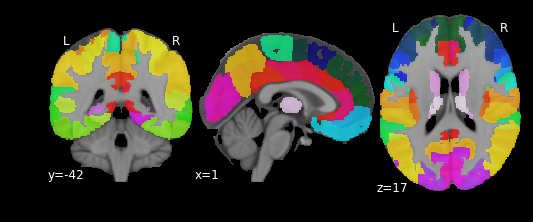

In [78]:
mni = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
plt.close()
plotting.plot_roi(ni.load('/Users/jakevogel/Downloads/BNA-maxprob-thr25-1mm.nii'), 
                  mni, draw_cross=False)
plt.show()


In [13]:
type(np.arange(5)) 

numpy.ndarray

In [12]:
any(x==19 for x in gdf.shape)

True

In [47]:
atl,coords = init_and_chk_inputs(atl_path,gdf[gdf.columns[-3:]].T)

checking and initializing inputs


In [51]:
xyz = np.array([convert_coords(coords[x],'xyz') for x in range(coords.shape[0])]).astype(int)

In [71]:
lab_vec = atl[xyz[:,0].tolist(),xyz[:,1].tolist(),xyz[:,2].tolist()]

In [77]:
len(lab_vec[lab_vec==0])

1430

In [61]:
max(xyz[:,2])

156

In [59]:
atl.shape

(182, 218, 182)

In [96]:
miss_idx = [int(x) for x in lab_vec if lab_vec[x] == 0]
miss_coords = xyz[miss_idx,0].tolist(),xyz[miss_idx,1].tolist(),xyz[miss_idx,2].tolist()

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


In [98]:
misses = np.zeros_like(atl)
misses[miss_coords] = 1 
miss_nii = ni.Nifti1Image(misses,
                          ni.load('/Users/jakevogel/Downloads/BNA-maxprob-thr25-1mm.nii').affine)


In [109]:
len(misses[miss_coords])

1348

In [104]:
miss_nii.to_filename('/Users/jakevogel/tmp/miss_nii')

//anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


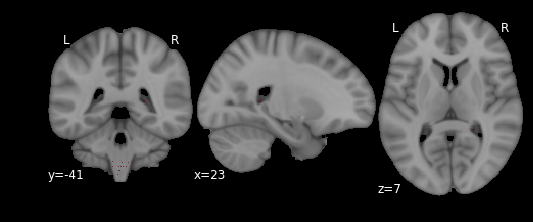

In [103]:
mni = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
plt.close()
plotting.plot_roi(miss_nii, mni, draw_cross=False, cmap='RdBu')
plt.show()

In [160]:
results = label_coordinate_by_atlas(atl_path,gdf[gdf.columns[-3:]])

checking and initializing inputs
extracting labels
completed
1430 coordinates were outside of the provided atlas


In [161]:
results = label_coordinate_by_atlas(atl_path,gdf[gdf.columns[-3:]], 3)

checking and initializing inputs
extracting labels
completed
990 coordinates were outside of the provided atlas


In [163]:
results

,Label
0,229.0
1,223.0
2,224.0
3,0.0
4,214.0
5,172.0
6,226.0
7,214.0
8,212.0
9,212.0


In [162]:
def label_coordinate_by_atlas(atlas, coordinates, cube_size = 1):
    ''' This function will take a set of coordinates and an atlas and return the
    atlas label for each coordinate. Optionally, a cube can be drawn around the 
    coordinate. In this case, the most frequent non-zero value inside the cube will 
    be selected as the label. The function will output a pandas dataframe with a
    label for each input coordinate.
    
    atlas can be a path to a nifti image, or a nifti object, or a 3D np.ndarray
    
    coordinates can be a pandas Dataframe, a numpy.ndarray or a list of lists, 
    representing the mni coordinates for each input corrdinate. as such, the 
    length of one of the dimensions should be 3
    
    cube_size represents the radius of the cube to be created. leaving it as 1 will
    only retrieve the value at the coordinate specified. Increasing the value will 
    draw a cube of increasing size and collect values from within the cube. The most
    frequent non-zero value within the cube will be selected
    
    '''
    
    # initiate and check inputs
    atl, coords = init_and_chk_inputs(atlas,coordinates)
    
    # convert coordinates to xyz space
    xyz = np.array([convert_coords(coords[x],'xyz') for x in range(coords.shape[0])
                   ]).astype(int)
    
    # create output container
    results = pandas.DataFrame(index=range(coords.shape[0]),columns = ['Label'])
    
    # get labels for each coordinate
    print('extracting labels')
    if cube_size == 1:
        results.loc[:,'Label'] = atl[xyz[:,0].tolist(),xyz[:,1].tolist(),xyz[:,2].tolist()]
    else:
        labs = []
        for i in range(xyz.shape[0]):
            labs.append(extract_value_from_cube(xyz[i,:], cube_size, atl))
        results.loc[:,'Label'] = labs
    
    print('completed')
    print('%s coordinates were outside of the provided atlas'%(
                                            len(results[results.Label==0])))

    return results
    
def init_and_chk_inputs(atlas,coordinates):
    print('checking and initializing inputs')
    if type(atlas) == str:
        atl = ni.load(atlas).get_data()
    elif type(atlas) == nibabel.nifti1.Nifti1Image: 
        atl = atlas.get_data()
    elif type(atlas) == numpy.core.memmap.memmap or type(atlas) == np.ndarray:
        atl = atlas
    else:
        raise IOError('atlas must be a nifti object, a numpy array or a path to a nifti file')
    
    if type(coordinates) == pandas.core.frame.DataFrame:
        coords = coordinates.values
       
    elif type(coordinates) == list or type(coordinates) == tuple:
        if len(coordinates)== 3:
            coords = np.zeros((len(coordinates[0]),3))
            for i in range(3):
                coords[:,i] = coords[i]
    elif type(coordinates) == np.ndarray:
        coords = coordinates
    else:
        raise IOError('coordiantes must be a pandas dataframe, numpy array or list of lists')
    
    if not any(x==3 for x in coords.shape):
        raise IOError('Coordinates are 3D and thus 3 columns are expected...')
    elif coords.shape[-1] != 3:
        coords = coords.T
    
    coords = coords.round()
    
    return atl,coords
    
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

def extract_value_from_cube(coord, radius, atl):
    
    xs,ys,zs = make_cube(coord, radius)
    cube_vals = atl[xs,ys,zs]
    if stats.mode(cube_vals)[0][0] == 0:
        if len(cube_vals[cube_vals!=0]) > 0:
            lab = stats.mode(cube_vals[cube_vals!=0])[0][0]
        else:
            lab = 0
    else:
        lab = stats.mode(cube_vals)[0][0]
    
    return lab
        
def make_cube(coord, radius):
    summers = []
    negrad = (radius*-1)+1
    for x in itertools.product(range(negrad,radius),repeat=3):
        summers.append(np.array(x))
    s_coords = [np.array(coord) + x for x in summers]
    xs = [int(x[0]) for x in s_coords]
    ys = [int(x[1]) for x in s_coords]
    zs = [int(x[2]) for x in s_coords]
    
    return xs, ys, zs

In [142]:
xs,ys,zs = make_cube(convert_coords(coords[50],'xyz'),3)

In [143]:
cube_vals = atl[xs,ys,zs]

In [150]:
stats.mode(cube_vals)[0][0]

25.0

In [152]:
len(cube_vals[cube_vals!=0])

82